In [1]:
import torch
from PIL import Image
import torchvision
import numpy as np
from detection_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomResize, Compose, ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn
from data import BedsoreDataset,BedsoreDataModule
from utils import batch2pil

In [2]:
net = maskrcnn_resnet50_fpn(pretrained=True)
in_features = net.roi_heads.box_predictor.cls_score.in_features
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, 7)

In [3]:
tfmc_train = Compose([ToTensor()])
ds = BedsoreDataset('data', transforms=tfmc_train)
image,target = ds[4]

In [4]:
target

{'boxes': tensor([[ 28.2734, 129.2988, 371.7831, 320.7009],
         [227.0000, 197.0000, 288.0000, 245.0000],
         [ 70.0000, 187.0000, 163.0000, 265.0000],
         [189.0000, 220.0000, 229.0000, 258.0000]]),
 'labels': tensor([5, 8, 7, 7]),
 'image_id': tensor([4]),
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

In [3]:
%debug

> /home/zrway/Projects/Bedsore/data.py(70)__getitem__()
     68 
     69         masks = torchvision.transforms.ToTensor()(masks)
---> 70         masks = torch.cat((pre_masks,masks),dim=0)
     71         target['masks'] = masks
     72         import ipdb; ipdb.set_trace()



ipdb>  pre_masks.shape


torch.Size([1, 424, 414])


ipdb>  masks.shape


torch.Size([414, 3, 424])


ipdb>  masks.shape


torch.Size([414, 3, 424])


ipdb>  q


In [17]:
net([image],[target])

/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


{'loss_classifier': tensor(2.0093, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0623, grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.4225, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.0339, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0044, grad_fn=<DivBackward0>)}

In [9]:
dm = BedsoreDataModule('data', 1)
dm.setup()

In [10]:
test_x  = next(iter(dm.val_dataloader()))[0]

In [1]:
from model import MyFasterRCNN

In [2]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/a3c2e29391714b9a8fa06defdba070f7/checkpoints/epoch=17.ckpt')

In [6]:
net = model.net
net.eval()
pass

In [12]:
out = net(test_x)

/home/zrway/anaconda3/lib/python3.7/site-packages/torchvision/ops/poolers.py:216: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_in_level = torch.nonzero(levels == level).squeeze(1)


In [48]:
mask = out[0]['masks'][0]

In [ ]:
torchvision.transforms.ToPILImage()((mask>0).float())

In [60]:
out[0]['masks'].max()

tensor(0.1052, grad_fn=<MaxBackward1>)

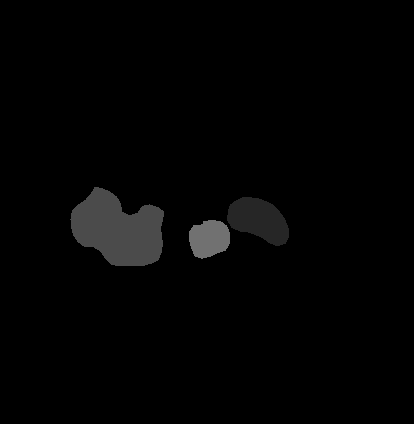

In [14]:
mask = Image.open('data/VOCdevkit/VOC2007/SegmentationObject/B01_00007.png').convert('L')
mask

In [19]:
mask = np.array(mask)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
obj_ids = np.unique(mask)[1:]
obj_ids

array([ 38,  75, 113], dtype=uint8)

In [22]:
masks = mask == obj_ids[:, None, None]

In [62]:
mask_cls = Image.open('data/VOCdevkit/VOC2007/SegmentationClass/B01_00007.png').convert('L')
mask_cls = np.array(mask_cls)
obj_ids = np.unique(mask_cls)[1:]
obj_ids

array([137, 173], dtype=uint8)

In [67]:
mask_clas = masks * mask_cls

In [84]:
mask_clas[0].max()

173

In [97]:
mask_clas.max(1).max(1)

array([173, 137, 137], dtype=uint8)

In [4]:
a = [132,43]

In [5]:
a == 132

False

### Load checkpoint and test

In [13]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil

In [14]:
dm = BedsoreDataModule(root='data',batch_size=1)
ds = dm.val_dataloader().dataset

In [15]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/eb7bc7ff8fca44fab1a2bf2113a73639/checkpoints/epoch=12.ckpt')
net = model.net
net.eval()
pass

In [34]:
idx = 6
image,target = ds[idx]
ds[idx]

(tensor([[[0.9098, 0.9059, 0.9059,  ..., 0.7333, 0.7333, 0.7333],
          [0.9059, 0.9059, 0.9020,  ..., 0.7333, 0.7333, 0.7333],
          [0.9059, 0.9020, 0.8980,  ..., 0.7333, 0.7333, 0.7333],
          ...,
          [0.1686, 0.1647, 0.1647,  ..., 0.6549, 0.6549, 0.6549],
          [0.1608, 0.1686, 0.1725,  ..., 0.6510, 0.6471, 0.6471],
          [0.1529, 0.1647, 0.1765,  ..., 0.6471, 0.6431, 0.6431]],
 
         [[0.9059, 0.9020, 0.9020,  ..., 0.6980, 0.6980, 0.6980],
          [0.9020, 0.9020, 0.8980,  ..., 0.6980, 0.6980, 0.6980],
          [0.9020, 0.8980, 0.8941,  ..., 0.6980, 0.6980, 0.6980],
          ...,
          [0.5843, 0.5804, 0.5804,  ..., 0.6392, 0.6392, 0.6392],
          [0.5765, 0.5843, 0.5882,  ..., 0.6353, 0.6314, 0.6314],
          [0.5686, 0.5804, 0.5922,  ..., 0.6314, 0.6275, 0.6275]],
 
         [[0.8902, 0.8863, 0.8863,  ..., 0.6392, 0.6392, 0.6392],
          [0.8863, 0.8863, 0.8824,  ..., 0.6392, 0.6392, 0.6392],
          [0.8863, 0.8824, 0.8784,  ...,

In [35]:
out = net([image],[target])[0]
out

{'boxes': tensor([[1166.4098,  288.2833, 2975.7261, 2912.3445],
         [1313.8258, 1115.2092, 2944.0996, 3204.6467],
         [1254.3882,  391.0949, 3006.2812, 2155.9133],
         [1661.0499,  953.3426, 2406.4275, 1668.7390],
         [1187.4618, 2041.1990, 3232.1587, 3212.3152],
         [1150.3193, 2084.5869, 3359.1565, 3122.5425],
         [1591.5380, 2103.0481, 3177.4719, 3131.0388],
         [1146.5187,  469.0390, 2927.7883, 1987.4622],
         [1969.5472, 2147.1741, 3078.6689, 3052.4944],
         [1018.3181, 1909.9637, 3309.0078, 3402.5718],
         [ 321.8701, 1505.3264,  907.8428, 1899.0015],
         [1547.4478,  744.7798, 2491.4810, 1623.9280],
         [1851.7643, 2127.6062, 3060.2769, 3027.3547],
         [1271.1968,  257.3778, 2804.8533, 2268.9370],
         [1117.3582,    0.0000, 3016.6970, 3176.3787],
         [1126.3722,    0.0000, 3081.7458, 3308.3608],
         [1156.4358, 1949.2996, 3388.7612, 3154.1130],
         [1387.2671,  519.1225, 2831.4714, 2117.6616],
 

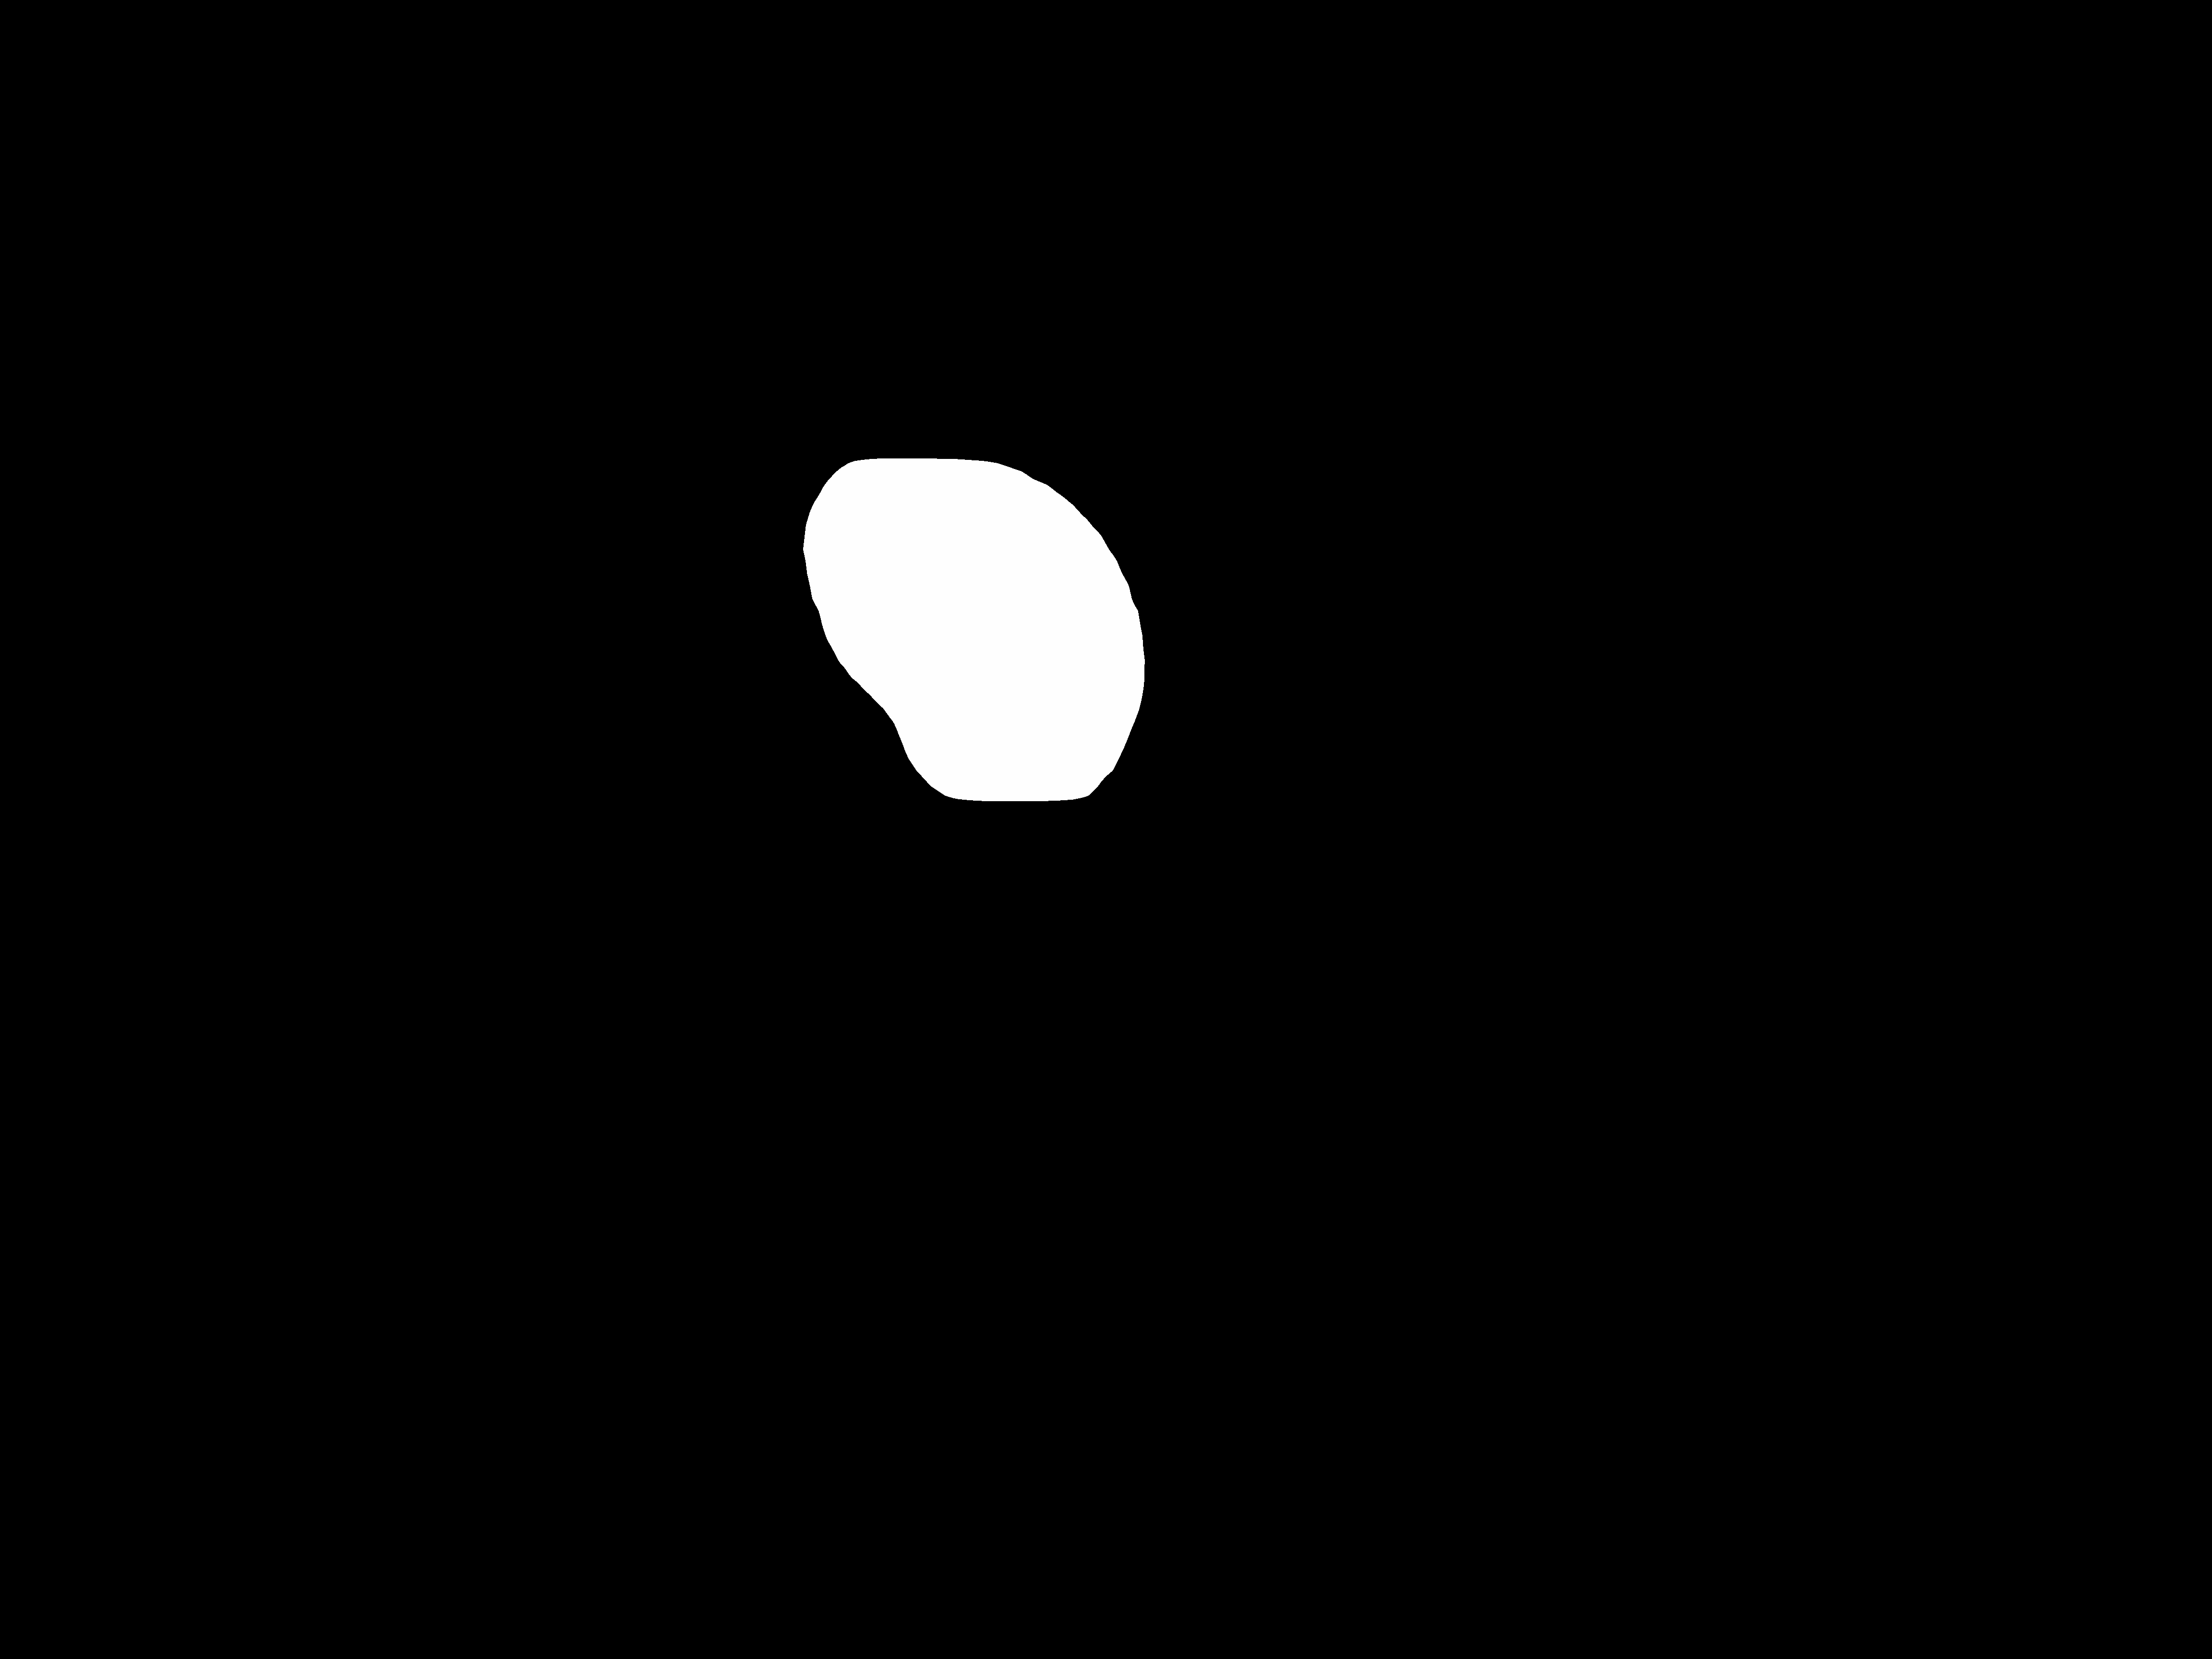

In [36]:
batch2pil(((out['masks'][3])>0.5).float())

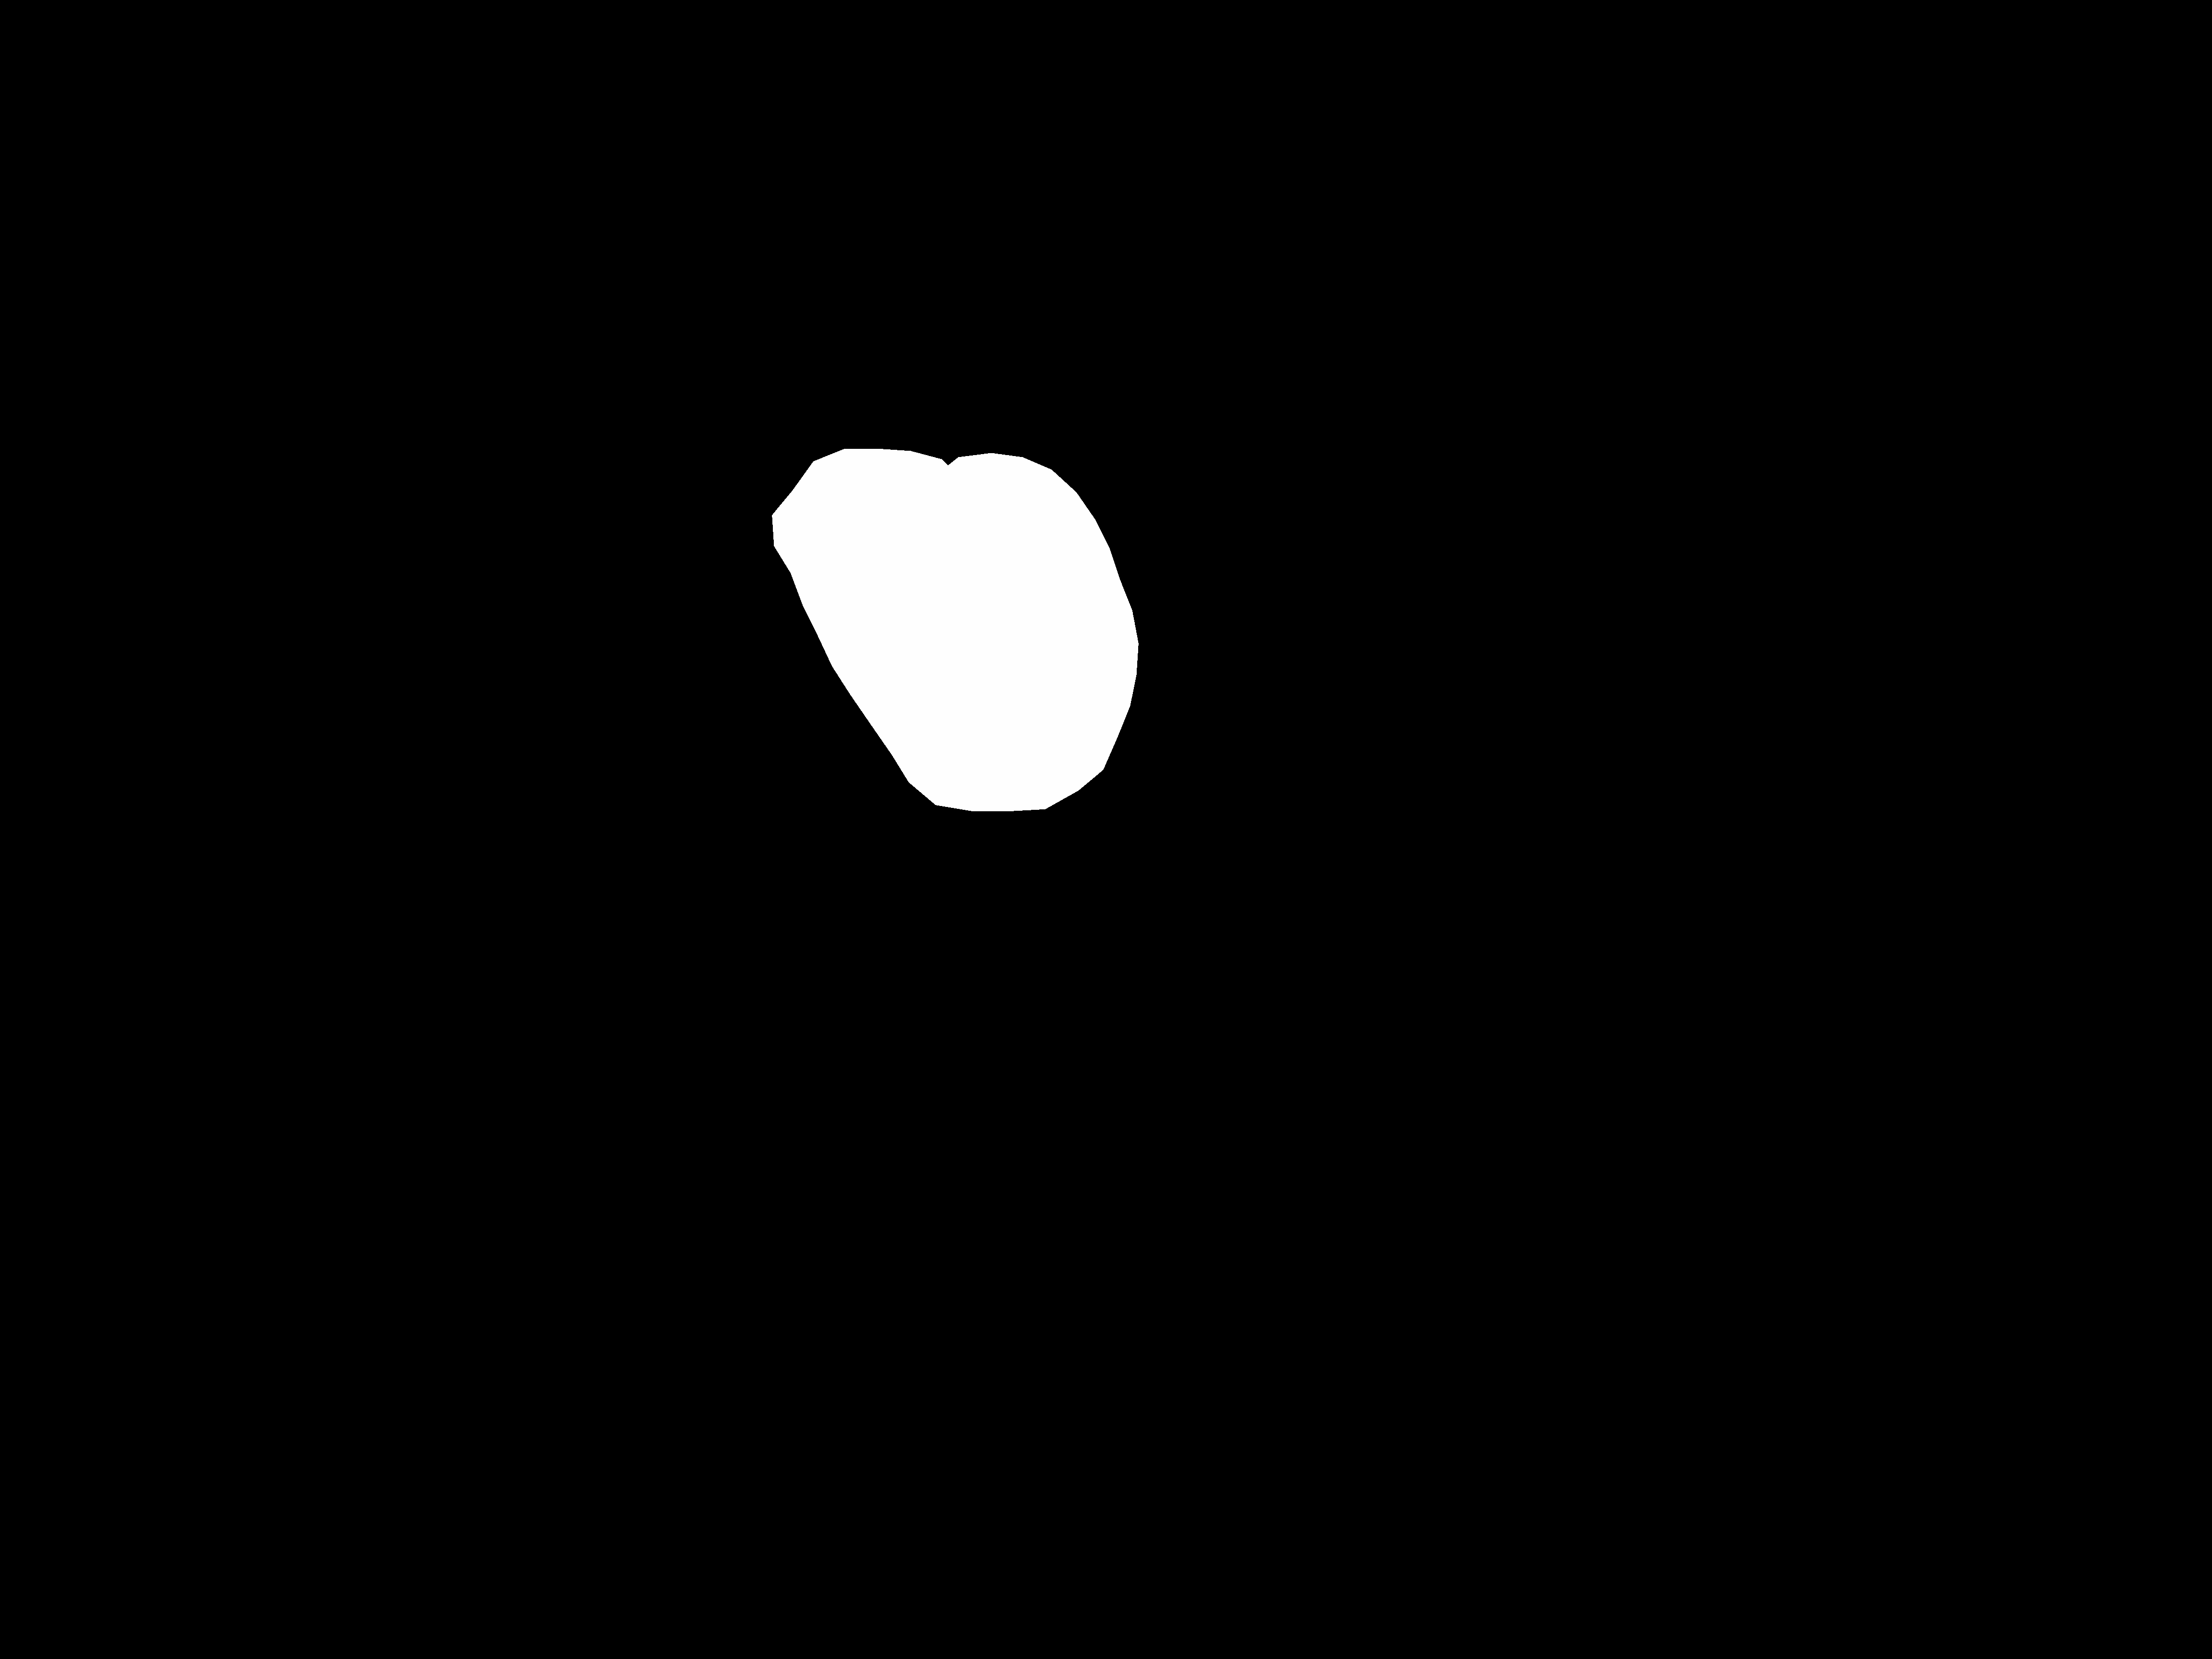

In [37]:
batch2pil(target['masks'][2])